In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from time import time
import matplotlib
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from sklearn.decomposition import PCA
tf.keras.backend.set_floatx('float64')
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
%matplotlib inline
print("tensorflow version: ", tf.__version__)
print("numpy version: ", np.__version__)
print("matplotlib version: ", matplotlib.__version__)
print("sklearn version: ", sklearn.__version__)

tensorflow version:  2.2.0
numpy version:  1.18.1
matplotlib version:  3.1.1
sklearn version:  0.23.2


<center> <h1> Creating the utils for the project</h1>

<b>Autor:</b> Edwin Rueda <br>
<b>email:</b> ejrueda95g@gmail.com <br>
<b>github:</b> https://github.com/ejrueda <br>
<b>website:</b> http://edwinrueda.com/ <br>
<b> You can cite this work with</b>:

@software{edwin_rueda_2020_3843381,<br>
  author       = {Edwin Rueda},<br>
  title        = {ejrueda/MasterUFPA: zenodo release},<br>
  month        = may,<br>
  year         = 2020,<br>
  publisher    = {Zenodo},<br>
  version      = {zenodo},<br>
  doi          = {10.5281/zenodo.3843381},<br>
  url          = {https://doi.org/10.5281/zenodo.3843381}<br>
}

### scaler
- The scaler class make a minmaxscaler operation in a dataframe, this allows that the dataframe keep your index.
- Parameters:
    - xmin: the min value of the scale
    - xmax: the max value of the scale
- Equation:
    - this scaling is computed by:
$$X_{new} = \frac{x-min(x)}{max(x) - min(x)} *(x_{max}-x_{min}) + x_{min}$$      

    where $x$ represents the dataframe, and $min(x)$ and $max(x)$, represents the minimum and maximum values per column in the dataframe.

In [2]:
class scaler:
    def __init__(self, xmin, xmax):
        """
        minmax scaler from dataframe
        """
        self.xmin = xmin
        self.xmax = xmax
        self.min_data = False
        self.max_data = False
        self.flag = False
        
    def fit(self, X):
        self.min_data = np.min(X).values
        self.max_data = np.max(X).values
        self.flag = True
        
    def transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler, called .fit()"
        X_r = X.copy()
        X_r = ((X_r - self.min_data)/(self.max_data - self.min_data))*(self.xmax-self.xmin) + self.xmin
        return X_r
    
    def inverse_transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler, called .fit()"
        X_r = X.copy()
        X_r = ((X_r - self.xmin)*(self.max_data - self.min_data)/(self.xmax - self.xmin)) + self.min_data
        return X_r

### Gan utils
- Gan utils is the class to create, train and evaluate the performance of a GAN architecture.

- Functions:
    - <b>kl_divergence:</b> compute the Kullback-Leibler divergence of the Discriminator network.
        - <b>parameters:</b>
            - <b>probability:</b> the probability of the discriminator network.
    - <b>train_gan:</b> this fuction combine the generator and discriminator networks and train the gan architecture. Note that this utils implements the tensorflow library, therefore, the G and D networks are not compiled, you just have to pass the networks without compile.
        - <b>parameters:</b>
            - <b>dataset:</b> a dataset to train the gan architecture, must be a tensorflow dataset.
            - <b>G:</b> generator model without training.
            - <b>D:</b> discriminator model without training.
            - <b>epochs:</b> number of epochs to train de gan architecture.
            - <b>batch_size:</b> the size of the batch to train de gan architecture.
            - <b>loss_function:</b> the loss funtion, in this case, this architecture must employ the binary_cross_entropy loss function.
        - <b>return:</b>
            - <b>accumulated_g_loss:</b> the generator loss by epochs in the architecture.
            - <b>accumulated_d_loss:</b> the discriminator loss by epochs in the architecture.
    - <b>train_step:</b> this function train the architecture over one batch. Note that this function is a tensorflow function.
        - <b>parameters:</b>
            - <b>sample:</b> batch to train the architecture. this batch must be a tensorflow batch.
            - <b>batch_size:</b> the size of the batch to train the architecture.
            - <b>loss_function:</b> the loss function of the architecture. Note that in these architectures, the loss function must be a binary_cross_entropy function.
            - <b>noise_input:</b> the size of the noise vector to train de generator network. In this approach, the noise vector is based in a normal distribution $N(0,1)$.
        - <b>return:</b>
            - <b>gen_loss:</b> the batch loss in the generator network.
            - <b>dis_loss:</b> the batch loss in the discriminator network.
    - <b>plot_results:</b> this function plots four different figures. 1) the cost function of the arquitecture. 2) the kullback-leibler divergence. 3) the precision of the D network. 4) the 2-PCA representation of the synthetic samples.
        - <b>parameters:</b>
            - <b>syn_size:</b> the number of synthetic samples to be generated.
        - <b>return:</b> 
            - <b>p:</b> plot containing the four figures.

In [3]:
class gan_utils:
    
    def __init__(self):
        self.accumulated_gloss = []
        self.accumulated_dloss = []
        self.precision = []
        self.recall = []
        self.kl_d = []
        self.X_train = None
        self.G = None
        self.D = None
        self.noise_input = None
    
    @tf.function
    def kl_divergence(self, probability):
        probability = tf.clip_by_value(probability, 1e-5, 1-1e-5)
        return tf.reduce_mean(probability*tf.math.log(probability/(1-probability)))
    
    @tf.function
    def binary_cross_entropy(self, prediction, target):
        """
        compute the loss for binary clasification problems
        """
        prediction = tf.clip_by_value(prediction, 1e-5, 1-1e-5)
        return -tf.reduce_mean(target*tf.math.log(prediction) + (1-target)*tf.math.log(1-prediction))

    @tf.function
    def train_step(self, sample, batch_size, noise_input, optimizerG, optimizerD):
        noise = tf.random.normal([batch_size, noise_input])
        with tf.GradientTape() as gG, tf.GradientTape() as gD:
            synthetic_data = self.G(noise, training=True)

            real_output = self.D(sample, training=True)
            fake_output = self.D(synthetic_data, training=True)

            gen_loss = self.binary_cross_entropy(fake_output, tf.ones_like(fake_output))
            dis_loss = .5*(self.binary_cross_entropy(real_output, tf.ones_like(real_output)) + self.binary_cross_entropy(fake_output,tf.zeros_like(fake_output)))

        g_generator = gG.gradient(gen_loss, self.G.trainable_variables)
        g_discriminator = gD.gradient(dis_loss, self.D.trainable_variables)

        optimizerG.apply_gradients(zip(g_generator, self.G.trainable_variables))
        optimizerD.apply_gradients(zip(g_discriminator, self.D.trainable_variables))

        return gen_loss, dis_loss
    
    def train(self, dataset, G, D, noise_input, epochs, batch_size, optimizerG, optimizerD):
        #reset metrics
        self.accumulated_gloss = []
        self.accumulated_dloss = []
        self.precision = []
        self.recall = []
        self.kld = []
        batch_g_loss = []
        batch_d_loss = []
        self.G, self.D = G, D
        self.noise_input = noise_input
        self.X_train = dataset
        batches = tf.data.Dataset.from_tensor_slices(dataset).batch(batch_size)
        for epoch in range(epochs):
            t_i = time()
            for batch in batches:
                batch_g_loss, batch_d_loss = self.train_step(batch, batch_size, noise_input,
                                                             optimizerG, optimizerD)
            self.accumulated_dloss.append(tf.reduce_mean(batch_d_loss))
            self.accumulated_gloss.append(tf.reduce_mean(batch_g_loss))

            X_sint = G(tf.random_normal_initializer(mean=0.0, stddev=1)([batch_size,noise_input],
                                                                        dtype=tf.float64))
            X_comb = tf.concat([dataset, X_sint], axis=0)
            y_comb = tf.concat([tf.ones((dataset.shape[0],1)), np.zeros((X_sint.shape[0],1))], axis=0)
            y_proba = D(X_comb)
            y_predict = tf.reshape((tf.greater(y_proba, .5).numpy()*1), [-1])
            self.kl_d.append(self.kl_divergence(y_proba).numpy())
            self.precision.append(precision_score(y_comb.numpy(), y_predict.numpy()))
            self.recall.append(recall_score(y_comb.numpy(), y_predict.numpy()))
            t_f = time()
            
            print("epochs[%d:%d] :: G_loss[%f] :: D_loss[%f] :: time:%f[s]"%(epoch, epochs,
                                                                             self.accumulated_gloss[-1],
                                                                             self.accumulated_dloss[-1],
                                                                             t_f-t_i))
        return self.accumulated_gloss, self.accumulated_dloss
        
    def plot_results(self, syn_size):
        fig = plt.figure(figsize=(15,10))
        for i in range(4):
            plt.subplot(2,2, i+1)
            if i==0:
                rr = range(0,len(self.accumulated_gloss), 3)
                short_g_loss = [self.accumulated_gloss[i] for i in rr]
                short_d_loss = [self.accumulated_dloss[i] for i in rr]
                plt.plot(rr, short_g_loss, label="Generator", color="#FFB248")
                plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4")
                plt.xlabel("Epochs", fontsize=13)
                plt.ylabel("Loss", fontsize=13)
                plt.grid(axis="y")
                plt.legend();
            elif i==1:
                plt.title("Divergencia de Kullback-Leibler", fontsize=14)
                plt.plot(range(len(self.kl_d)), self.kl_d, linewidth=.5)
                plt.plot(range(len(self.kl_d)), np.zeros(len(self.kl_d)))
                plt.grid()
                plt.xlabel("Epochs");
                plt.ylabel("Divergencia de Kullback-Leibler");
            elif i==2:
                short_precision = [self.precision[v] for v in rr]
                plt.plot(rr, short_precision, linewidth=.8, label="precision")
                plt.grid(axis="y")
                plt.plot(rr, np.ones(len(short_precision))*.5,
                         label="target", linestyle="--")
                plt.legend();
            elif i==3:
                pca = PCA(n_components=2)
                X_real_pca = pca.fit_transform(self.X_train.numpy())
                noise = tf.random.normal([syn_size, self.noise_input])
                synthetics = self.G(noise)
                X_fake_pca = pca.transform(synthetics.numpy())
                plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], label="synthetic", alpha=.4, color="orange",
                           edgecolors="red");
                plt.scatter(X_real_pca[:,0], X_real_pca[:,1], label="real", marker="*", s=80, color="green",
                            edgecolors="black");
        return fig
    
    
    def get_metrics(self, num_iter):
        """
        this function returns the metrics obtained after
        training the architecture
        num_iter: number of iterations to compute the boxplot
        return: precision of the discriminator network, Kullback-Leibler divergence
                loss of the generator network, loss of the discriminator network
        """
        precision_d = []
        kld_divergence = []
        g_loss = []
        d_loss = []
        for i in range(num_iter):
            noise = tf.random.normal([self.X_train.shape[0], self.noise_input])
            synthetic_samples = self.G(noise)
            X_comb = tf.concat([self.X_train, synthetic_samples], axis=0)
            y_comb = tf.concat([tf.ones((self.X_train.shape[0],1), dtype=tf.float64),
                                tf.zeros((synthetic_samples.shape[0],1), dtype=tf.float64)], axis=0)
            y_proba = self.D(X_comb)
            y_predict = tf.reshape((tf.greater(y_proba, .5).numpy()*1), [-1])
            precision_d.append(precision_score(y_comb.numpy(), y_predict))
            kld_divergence.append(self.kl_divergence(y_proba).numpy())
            g_loss.append(self.binary_cross_entropy(self.D(synthetic_samples),
                                                    tf.zeros(synthetic_samples.shape[0], dtype=tf.float64)).numpy())
            d_loss.append(self.binary_cross_entropy(y_proba, y_comb).numpy())
            
        return precision_d, kld_divergence, g_loss, d_loss

In [4]:
#----------------------------------------------------------
#-------------- bokeh_utils class -------------------------
#----------------------------------------------------------
class bokeh_utils:
    """
    this class contains functions to facilitate the use of the bokeh library
    """
    def __init__(self):
        pass
    
    def boxtplot_values(self, v):  
        """
        This function returns the values to plot a boxplot in the bokeh library
        parameters: 
            v: array with the values to make a boxplot
        return: [lower, quantile25, quantile50, quantile75, upper] and outliers
        """
        q25 = np.quantile(v, q=.25, interpolation="midpoint")
        q50 = np.quantile(v, q=.5, interpolation="midpoint")
        q75 = np.quantile(v, q=.75, interpolation="midpoint")
        lower = q25 - 1.5*(q75-q25)
        upper = q75 + 1.5*(q75-q25)
        #outliers
        outliers = v[(v<lower)|(v>upper)]

        return [lower, q25, q50, q75, upper], outliers

###  Test

In [5]:
data = pd.read_csv("../data/all_counts_9_norm_rpkm_log2_preprocessed.csv",
                  index_col=0)
r_g = open("../data/reference_genes.txt").read().splitlines()
r_g.remove("idnT")
X_train = data.loc[r_g]
X_train.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964


In [6]:
obj_scaler = scaler(xmin=-1, xmax=1)
obj_scaler.fit(X_train)
X_train = obj_scaler.transform(X_train)
X_train.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377


In [7]:
X_train = tf.Variable(np.array(X_train))

In [8]:
noise_input = 50

In [9]:
@tf.function
def my_binary_cross_entropy(prediction, target):
    """
    compute the loss for binary clasification problems
    """
    prediction = tf.clip_by_value(prediction, 1e-5, 1-1e-5)
    return -tf.reduce_mean(target*tf.math.log(prediction) + (1-target)*tf.math.log(1-prediction))

In [10]:
G = Sequential()
G.add(Dense(noise_input, input_shape=(noise_input,)))
G.add(Dense(50)) #64
G.add(Dense(150)) #64
G.add(tf.keras.layers.Dropout(.15))
G.add(Dense(9, activation="tanh"))

D = Sequential()
D.add(Dense(32, input_shape=(9,)))
D.add(tf.keras.layers.LeakyReLU(alpha=.2)) #función rectificadora
D.add(Dense(32))
#D.add(tf.keras.layers.Dropout(.1))
D.add(Dense(1, activation='sigmoid'))

In [11]:
noise = tf.random_normal_initializer(mean=0.0, stddev=1)([1,noise_input], dtype=tf.float64)
print("shape of the input noise:", noise.shape)
synthetic_sample = G(noise)
print("shape of the synthetic sample:", synthetic_sample.shape)
print("prediction of the D network:", D(synthetic_sample))
#print("loss of the D network:", my_binary_cross_entropy(D(synthetic_sample), 0))

shape of the input noise: (1, 50)
shape of the synthetic sample: (1, 9)
prediction of the D network: tf.Tensor([[0.78114838]], shape=(1, 1), dtype=float64)


In [12]:
batch_size = 20
ep = 1700
#optimizerG = tf.optimizers.SGD(lr=0.00014, momentum=0.92, decay=0.00014/ep)
#optimizerD = tf.optimizers.SGD(lr=0.0011, momentum=0.9, decay=0.0011/ep)

optimizerG = tf.optimizers.SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
optimizerD = tf.optimizers.SGD(lr=0.0011, momentum=0.9, decay=0.0011/ep)

In [13]:
utils = gan_utils()
gloss, dloss = utils.train(X_train, G, D, noise_input, ep, batch_size, optimizerG, optimizerD)

epochs[0:1700] :: G_loss[0.550697] :: D_loss[0.773486] :: time:1.286561[s]
epochs[1:1700] :: G_loss[0.518935] :: D_loss[0.805524] :: time:0.008316[s]
epochs[2:1700] :: G_loss[0.485831] :: D_loss[0.834264] :: time:0.010792[s]
epochs[3:1700] :: G_loss[0.530097] :: D_loss[0.783347] :: time:0.009322[s]
epochs[4:1700] :: G_loss[0.549915] :: D_loss[0.756972] :: time:0.009524[s]
epochs[5:1700] :: G_loss[0.591081] :: D_loss[0.733817] :: time:0.010642[s]
epochs[6:1700] :: G_loss[0.539183] :: D_loss[0.785226] :: time:0.008223[s]
epochs[7:1700] :: G_loss[0.611390] :: D_loss[0.718880] :: time:0.010608[s]
epochs[8:1700] :: G_loss[0.616828] :: D_loss[0.721697] :: time:0.008259[s]
epochs[9:1700] :: G_loss[0.515579] :: D_loss[0.801733] :: time:0.010286[s]
epochs[10:1700] :: G_loss[0.538572] :: D_loss[0.788744] :: time:0.009316[s]
epochs[11:1700] :: G_loss[0.516416] :: D_loss[0.791910] :: time:0.008899[s]
epochs[12:1700] :: G_loss[0.523834] :: D_loss[0.797871] :: time:0.010597[s]
epochs[13:1700] :: G_l

epochs[114:1700] :: G_loss[0.682077] :: D_loss[0.650437] :: time:0.015504[s]
epochs[115:1700] :: G_loss[0.659857] :: D_loss[0.666766] :: time:0.015702[s]
epochs[116:1700] :: G_loss[0.665043] :: D_loss[0.659834] :: time:0.017138[s]
epochs[117:1700] :: G_loss[0.665132] :: D_loss[0.661185] :: time:0.011277[s]
epochs[118:1700] :: G_loss[0.711842] :: D_loss[0.636906] :: time:0.020722[s]
epochs[119:1700] :: G_loss[0.664075] :: D_loss[0.670321] :: time:0.008940[s]
epochs[120:1700] :: G_loss[0.639175] :: D_loss[0.674961] :: time:0.012832[s]
epochs[121:1700] :: G_loss[0.679757] :: D_loss[0.653508] :: time:0.011513[s]
epochs[122:1700] :: G_loss[0.728217] :: D_loss[0.629884] :: time:0.008456[s]
epochs[123:1700] :: G_loss[0.683755] :: D_loss[0.647580] :: time:0.011517[s]
epochs[124:1700] :: G_loss[0.705350] :: D_loss[0.644001] :: time:0.010927[s]
epochs[125:1700] :: G_loss[0.713351] :: D_loss[0.635943] :: time:0.009494[s]
epochs[126:1700] :: G_loss[0.723982] :: D_loss[0.630200] :: time:0.018869[s]

epochs[235:1700] :: G_loss[0.780101] :: D_loss[0.597177] :: time:0.014665[s]
epochs[236:1700] :: G_loss[0.841658] :: D_loss[0.571196] :: time:0.023486[s]
epochs[237:1700] :: G_loss[0.738868] :: D_loss[0.620480] :: time:0.018744[s]
epochs[238:1700] :: G_loss[0.771142] :: D_loss[0.601994] :: time:0.019313[s]
epochs[239:1700] :: G_loss[0.745204] :: D_loss[0.617375] :: time:0.017161[s]
epochs[240:1700] :: G_loss[0.732075] :: D_loss[0.625739] :: time:0.018133[s]
epochs[241:1700] :: G_loss[0.726629] :: D_loss[0.633905] :: time:0.029016[s]
epochs[242:1700] :: G_loss[0.816326] :: D_loss[0.580826] :: time:0.010695[s]
epochs[243:1700] :: G_loss[0.740818] :: D_loss[0.620258] :: time:0.019300[s]
epochs[244:1700] :: G_loss[0.739049] :: D_loss[0.621232] :: time:0.010302[s]
epochs[245:1700] :: G_loss[0.771086] :: D_loss[0.603114] :: time:0.017806[s]
epochs[246:1700] :: G_loss[0.744697] :: D_loss[0.618122] :: time:0.017774[s]
epochs[247:1700] :: G_loss[0.759018] :: D_loss[0.605438] :: time:0.018661[s]

epochs[363:1700] :: G_loss[0.814013] :: D_loss[0.584518] :: time:0.008436[s]
epochs[364:1700] :: G_loss[0.875866] :: D_loss[0.555263] :: time:0.009886[s]
epochs[365:1700] :: G_loss[0.882616] :: D_loss[0.554929] :: time:0.011701[s]
epochs[366:1700] :: G_loss[0.893526] :: D_loss[0.548130] :: time:0.009096[s]
epochs[367:1700] :: G_loss[0.816593] :: D_loss[0.578130] :: time:0.008582[s]
epochs[368:1700] :: G_loss[0.883381] :: D_loss[0.547110] :: time:0.008619[s]
epochs[369:1700] :: G_loss[0.764435] :: D_loss[0.606076] :: time:0.008974[s]
epochs[370:1700] :: G_loss[0.846508] :: D_loss[0.565133] :: time:0.008494[s]
epochs[371:1700] :: G_loss[0.850622] :: D_loss[0.572194] :: time:0.008490[s]
epochs[372:1700] :: G_loss[0.966221] :: D_loss[0.516519] :: time:0.008436[s]
epochs[373:1700] :: G_loss[0.886334] :: D_loss[0.546657] :: time:0.008739[s]
epochs[374:1700] :: G_loss[0.835086] :: D_loss[0.576082] :: time:0.009012[s]
epochs[375:1700] :: G_loss[0.829876] :: D_loss[0.568373] :: time:0.012394[s]

epochs[475:1700] :: G_loss[0.908851] :: D_loss[0.544676] :: time:0.010810[s]
epochs[476:1700] :: G_loss[0.858641] :: D_loss[0.580373] :: time:0.012835[s]
epochs[477:1700] :: G_loss[0.966259] :: D_loss[0.522030] :: time:0.008782[s]
epochs[478:1700] :: G_loss[0.843226] :: D_loss[0.570640] :: time:0.008858[s]
epochs[479:1700] :: G_loss[0.852699] :: D_loss[0.588541] :: time:0.008931[s]
epochs[480:1700] :: G_loss[0.953420] :: D_loss[0.553972] :: time:0.008839[s]
epochs[481:1700] :: G_loss[0.852637] :: D_loss[0.580821] :: time:0.008428[s]
epochs[482:1700] :: G_loss[0.922458] :: D_loss[0.540438] :: time:0.008890[s]
epochs[483:1700] :: G_loss[0.968095] :: D_loss[0.519664] :: time:0.008279[s]
epochs[484:1700] :: G_loss[0.909329] :: D_loss[0.546132] :: time:0.008526[s]
epochs[485:1700] :: G_loss[0.941075] :: D_loss[0.529615] :: time:0.008149[s]
epochs[486:1700] :: G_loss[0.886324] :: D_loss[0.551746] :: time:0.008502[s]
epochs[487:1700] :: G_loss[0.852423] :: D_loss[0.568874] :: time:0.008254[s]

epochs[583:1700] :: G_loss[0.776919] :: D_loss[0.613510] :: time:0.012620[s]
epochs[584:1700] :: G_loss[0.918611] :: D_loss[0.565155] :: time:0.010539[s]
epochs[585:1700] :: G_loss[0.956602] :: D_loss[0.544453] :: time:0.009288[s]
epochs[586:1700] :: G_loss[0.957084] :: D_loss[0.548118] :: time:0.009243[s]
epochs[587:1700] :: G_loss[0.845613] :: D_loss[0.583423] :: time:0.008941[s]
epochs[588:1700] :: G_loss[0.962649] :: D_loss[0.545808] :: time:0.008622[s]
epochs[589:1700] :: G_loss[0.823781] :: D_loss[0.592946] :: time:0.008728[s]
epochs[590:1700] :: G_loss[0.887138] :: D_loss[0.572684] :: time:0.008829[s]
epochs[591:1700] :: G_loss[0.895769] :: D_loss[0.575304] :: time:0.008457[s]
epochs[592:1700] :: G_loss[0.894640] :: D_loss[0.564543] :: time:0.011967[s]
epochs[593:1700] :: G_loss[0.916034] :: D_loss[0.559720] :: time:0.011242[s]
epochs[594:1700] :: G_loss[1.024941] :: D_loss[0.520982] :: time:0.011321[s]
epochs[595:1700] :: G_loss[0.775413] :: D_loss[0.632394] :: time:0.013917[s]

epochs[693:1700] :: G_loss[0.760249] :: D_loss[0.680040] :: time:0.011187[s]
epochs[694:1700] :: G_loss[0.722185] :: D_loss[0.672625] :: time:0.011018[s]
epochs[695:1700] :: G_loss[0.892315] :: D_loss[0.600199] :: time:0.009110[s]
epochs[696:1700] :: G_loss[0.862672] :: D_loss[0.607384] :: time:0.010636[s]
epochs[697:1700] :: G_loss[0.788212] :: D_loss[0.644298] :: time:0.008580[s]
epochs[698:1700] :: G_loss[0.953412] :: D_loss[0.574113] :: time:0.009022[s]
epochs[699:1700] :: G_loss[0.735060] :: D_loss[0.674849] :: time:0.008628[s]
epochs[700:1700] :: G_loss[0.806720] :: D_loss[0.647390] :: time:0.009018[s]
epochs[701:1700] :: G_loss[0.839136] :: D_loss[0.657844] :: time:0.008894[s]
epochs[702:1700] :: G_loss[0.796468] :: D_loss[0.650239] :: time:0.008521[s]
epochs[703:1700] :: G_loss[0.931644] :: D_loss[0.594623] :: time:0.008531[s]
epochs[704:1700] :: G_loss[0.965247] :: D_loss[0.566523] :: time:0.008443[s]
epochs[705:1700] :: G_loss[0.842538] :: D_loss[0.626149] :: time:0.009650[s]

epochs[801:1700] :: G_loss[0.831416] :: D_loss[0.657647] :: time:0.015686[s]
epochs[802:1700] :: G_loss[0.838068] :: D_loss[0.655416] :: time:0.017355[s]
epochs[803:1700] :: G_loss[0.764852] :: D_loss[0.710859] :: time:0.025892[s]
epochs[804:1700] :: G_loss[0.885681] :: D_loss[0.640783] :: time:0.008897[s]
epochs[805:1700] :: G_loss[0.654023] :: D_loss[0.790381] :: time:0.008450[s]
epochs[806:1700] :: G_loss[0.756764] :: D_loss[0.686511] :: time:0.008508[s]
epochs[807:1700] :: G_loss[0.745651] :: D_loss[0.700117] :: time:0.008285[s]
epochs[808:1700] :: G_loss[0.892765] :: D_loss[0.632797] :: time:0.008366[s]
epochs[809:1700] :: G_loss[0.973182] :: D_loss[0.584417] :: time:0.008381[s]
epochs[810:1700] :: G_loss[0.879533] :: D_loss[0.632916] :: time:0.009327[s]
epochs[811:1700] :: G_loss[0.811770] :: D_loss[0.662366] :: time:0.008428[s]
epochs[812:1700] :: G_loss[0.831459] :: D_loss[0.651323] :: time:0.008563[s]
epochs[813:1700] :: G_loss[0.840648] :: D_loss[0.654188] :: time:0.009522[s]

epochs[912:1700] :: G_loss[0.724634] :: D_loss[0.701128] :: time:0.013000[s]
epochs[913:1700] :: G_loss[0.811838] :: D_loss[0.688928] :: time:0.009920[s]
epochs[914:1700] :: G_loss[0.737036] :: D_loss[0.708002] :: time:0.010205[s]
epochs[915:1700] :: G_loss[0.769016] :: D_loss[0.695139] :: time:0.009028[s]
epochs[916:1700] :: G_loss[0.705309] :: D_loss[0.722839] :: time:0.008726[s]
epochs[917:1700] :: G_loss[0.822519] :: D_loss[0.673008] :: time:0.008211[s]
epochs[918:1700] :: G_loss[0.665895] :: D_loss[0.736228] :: time:0.009151[s]
epochs[919:1700] :: G_loss[0.760691] :: D_loss[0.690023] :: time:0.008587[s]
epochs[920:1700] :: G_loss[0.764641] :: D_loss[0.692901] :: time:0.008256[s]
epochs[921:1700] :: G_loss[0.785599] :: D_loss[0.688378] :: time:0.008556[s]
epochs[922:1700] :: G_loss[0.801201] :: D_loss[0.674027] :: time:0.008135[s]
epochs[923:1700] :: G_loss[0.732224] :: D_loss[0.709909] :: time:0.008339[s]
epochs[924:1700] :: G_loss[0.792367] :: D_loss[0.709439] :: time:0.008253[s]

epochs[1019:1700] :: G_loss[0.742461] :: D_loss[0.719639] :: time:0.010391[s]
epochs[1020:1700] :: G_loss[0.787911] :: D_loss[0.703398] :: time:0.010765[s]
epochs[1021:1700] :: G_loss[0.841324] :: D_loss[0.672601] :: time:0.012927[s]
epochs[1022:1700] :: G_loss[0.884800] :: D_loss[0.657886] :: time:0.012110[s]
epochs[1023:1700] :: G_loss[0.781841] :: D_loss[0.692060] :: time:0.008949[s]
epochs[1024:1700] :: G_loss[0.762520] :: D_loss[0.703908] :: time:0.008860[s]
epochs[1025:1700] :: G_loss[0.788603] :: D_loss[0.688798] :: time:0.008352[s]
epochs[1026:1700] :: G_loss[0.800479] :: D_loss[0.695137] :: time:0.008508[s]
epochs[1027:1700] :: G_loss[0.760018] :: D_loss[0.693871] :: time:0.008261[s]
epochs[1028:1700] :: G_loss[0.754388] :: D_loss[0.703196] :: time:0.008307[s]
epochs[1029:1700] :: G_loss[0.793748] :: D_loss[0.684634] :: time:0.008249[s]
epochs[1030:1700] :: G_loss[0.759488] :: D_loss[0.703086] :: time:0.008584[s]
epochs[1031:1700] :: G_loss[0.794489] :: D_loss[0.702060] :: tim

epochs[1132:1700] :: G_loss[0.778519] :: D_loss[0.691380] :: time:0.011902[s]
epochs[1133:1700] :: G_loss[0.701686] :: D_loss[0.719855] :: time:0.010746[s]
epochs[1134:1700] :: G_loss[0.791197] :: D_loss[0.684546] :: time:0.009784[s]
epochs[1135:1700] :: G_loss[0.838250] :: D_loss[0.669523] :: time:0.008901[s]
epochs[1136:1700] :: G_loss[0.727421] :: D_loss[0.707119] :: time:0.008754[s]
epochs[1137:1700] :: G_loss[0.766475] :: D_loss[0.693850] :: time:0.008355[s]
epochs[1138:1700] :: G_loss[0.829060] :: D_loss[0.664129] :: time:0.008606[s]
epochs[1139:1700] :: G_loss[0.722677] :: D_loss[0.713397] :: time:0.008259[s]
epochs[1140:1700] :: G_loss[0.818322] :: D_loss[0.679358] :: time:0.008482[s]
epochs[1141:1700] :: G_loss[0.707253] :: D_loss[0.721730] :: time:0.008139[s]
epochs[1142:1700] :: G_loss[0.741255] :: D_loss[0.700469] :: time:0.008511[s]
epochs[1143:1700] :: G_loss[0.856015] :: D_loss[0.658186] :: time:0.008336[s]
epochs[1144:1700] :: G_loss[0.779782] :: D_loss[0.688915] :: tim

epochs[1247:1700] :: G_loss[0.743704] :: D_loss[0.695726] :: time:0.009247[s]
epochs[1248:1700] :: G_loss[0.775736] :: D_loss[0.675570] :: time:0.012522[s]
epochs[1249:1700] :: G_loss[0.820421] :: D_loss[0.663297] :: time:0.009338[s]
epochs[1250:1700] :: G_loss[0.705584] :: D_loss[0.708666] :: time:0.010628[s]
epochs[1251:1700] :: G_loss[0.755539] :: D_loss[0.688878] :: time:0.008242[s]
epochs[1252:1700] :: G_loss[0.829857] :: D_loss[0.660978] :: time:0.008973[s]
epochs[1253:1700] :: G_loss[0.751645] :: D_loss[0.689119] :: time:0.008188[s]
epochs[1254:1700] :: G_loss[0.756872] :: D_loss[0.684176] :: time:0.008590[s]
epochs[1255:1700] :: G_loss[0.763792] :: D_loss[0.682532] :: time:0.008435[s]
epochs[1256:1700] :: G_loss[0.798672] :: D_loss[0.672634] :: time:0.008610[s]
epochs[1257:1700] :: G_loss[0.697396] :: D_loss[0.712102] :: time:0.008417[s]
epochs[1258:1700] :: G_loss[0.778668] :: D_loss[0.675023] :: time:0.008641[s]
epochs[1259:1700] :: G_loss[0.771505] :: D_loss[0.676436] :: tim

epochs[1357:1700] :: G_loss[0.718219] :: D_loss[0.700478] :: time:0.009813[s]
epochs[1358:1700] :: G_loss[0.717707] :: D_loss[0.699078] :: time:0.012846[s]
epochs[1359:1700] :: G_loss[0.774171] :: D_loss[0.683892] :: time:0.008291[s]
epochs[1360:1700] :: G_loss[0.746247] :: D_loss[0.686690] :: time:0.008628[s]
epochs[1361:1700] :: G_loss[0.764756] :: D_loss[0.677816] :: time:0.008800[s]
epochs[1362:1700] :: G_loss[0.791232] :: D_loss[0.667880] :: time:0.010559[s]
epochs[1363:1700] :: G_loss[0.766823] :: D_loss[0.679648] :: time:0.008835[s]
epochs[1364:1700] :: G_loss[0.815105] :: D_loss[0.659104] :: time:0.009174[s]
epochs[1365:1700] :: G_loss[0.733083] :: D_loss[0.695147] :: time:0.008718[s]
epochs[1366:1700] :: G_loss[0.788589] :: D_loss[0.671176] :: time:0.008553[s]
epochs[1367:1700] :: G_loss[0.723906] :: D_loss[0.700654] :: time:0.008685[s]
epochs[1368:1700] :: G_loss[0.746356] :: D_loss[0.688202] :: time:0.008420[s]
epochs[1369:1700] :: G_loss[0.819852] :: D_loss[0.659968] :: tim

epochs[1463:1700] :: G_loss[0.761047] :: D_loss[0.676744] :: time:0.013327[s]
epochs[1464:1700] :: G_loss[0.768656] :: D_loss[0.669893] :: time:0.013356[s]
epochs[1465:1700] :: G_loss[0.771872] :: D_loss[0.678016] :: time:0.010137[s]
epochs[1466:1700] :: G_loss[0.770463] :: D_loss[0.673216] :: time:0.009040[s]
epochs[1467:1700] :: G_loss[0.736937] :: D_loss[0.692879] :: time:0.009274[s]
epochs[1468:1700] :: G_loss[0.768025] :: D_loss[0.678515] :: time:0.008819[s]
epochs[1469:1700] :: G_loss[0.772468] :: D_loss[0.672087] :: time:0.008826[s]
epochs[1470:1700] :: G_loss[0.831930] :: D_loss[0.647955] :: time:0.009020[s]
epochs[1471:1700] :: G_loss[0.742705] :: D_loss[0.682640] :: time:0.008900[s]
epochs[1472:1700] :: G_loss[0.811884] :: D_loss[0.655710] :: time:0.008738[s]
epochs[1473:1700] :: G_loss[0.815994] :: D_loss[0.656198] :: time:0.008999[s]
epochs[1474:1700] :: G_loss[0.801323] :: D_loss[0.662613] :: time:0.008727[s]
epochs[1475:1700] :: G_loss[0.776084] :: D_loss[0.673064] :: tim

epochs[1575:1700] :: G_loss[0.686296] :: D_loss[0.701624] :: time:0.011816[s]
epochs[1576:1700] :: G_loss[0.727089] :: D_loss[0.678128] :: time:0.010964[s]
epochs[1577:1700] :: G_loss[0.727343] :: D_loss[0.681151] :: time:0.010350[s]
epochs[1578:1700] :: G_loss[0.759402] :: D_loss[0.664965] :: time:0.008492[s]
epochs[1579:1700] :: G_loss[0.745048] :: D_loss[0.672686] :: time:0.008613[s]
epochs[1580:1700] :: G_loss[0.646194] :: D_loss[0.722357] :: time:0.008371[s]
epochs[1581:1700] :: G_loss[0.718618] :: D_loss[0.693512] :: time:0.008662[s]
epochs[1582:1700] :: G_loss[0.770079] :: D_loss[0.661479] :: time:0.008415[s]
epochs[1583:1700] :: G_loss[0.701096] :: D_loss[0.695199] :: time:0.008402[s]
epochs[1584:1700] :: G_loss[0.706427] :: D_loss[0.692719] :: time:0.008401[s]
epochs[1585:1700] :: G_loss[0.725385] :: D_loss[0.685863] :: time:0.008666[s]
epochs[1586:1700] :: G_loss[0.708831] :: D_loss[0.692168] :: time:0.008389[s]
epochs[1587:1700] :: G_loss[0.711487] :: D_loss[0.691899] :: tim

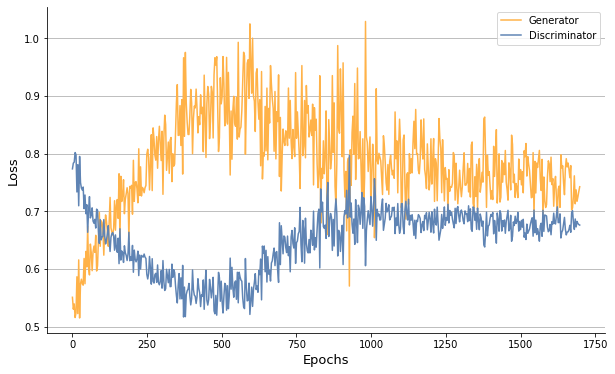

In [14]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(gloss), 3)
short_g_loss = [gloss[i] for i in rr]
short_d_loss = [dloss[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(rr, short_g_loss, label="Generator", color="#FFB248")
plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4")
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.grid(axis="y")
plt.legend();

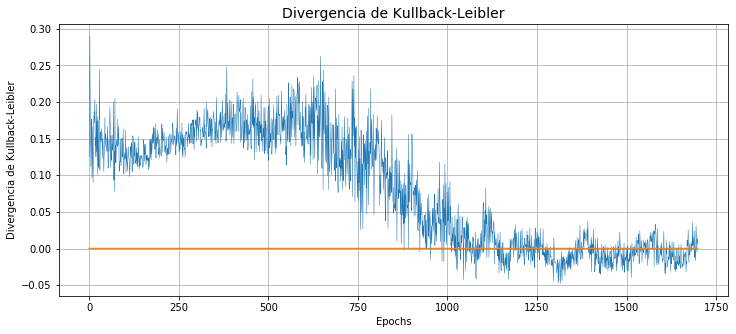

In [15]:
plt.figure(figsize=(12,5))
plt.title("Divergencia de Kullback-Leibler", fontsize=14)
plt.plot(range(len(utils.kl_d)), utils.kl_d, linewidth=.5)
plt.plot(range(len(utils.kl_d)), np.zeros(len(utils.kl_d)))
plt.grid()
plt.xlabel("Epochs");
plt.ylabel("Divergencia de Kullback-Leibler");

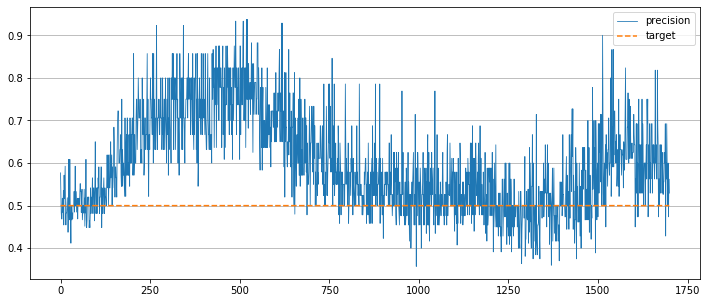

In [16]:
fig = plt.figure(figsize=(12,5))
plt.plot(range(len(utils.precision)), utils.precision, linewidth=.8, label="precision")
plt.grid(axis="y")
plt.plot(range(len(utils.precision)), np.ones(len(utils.precision))*.5, label="target", linestyle="--")
plt.legend();

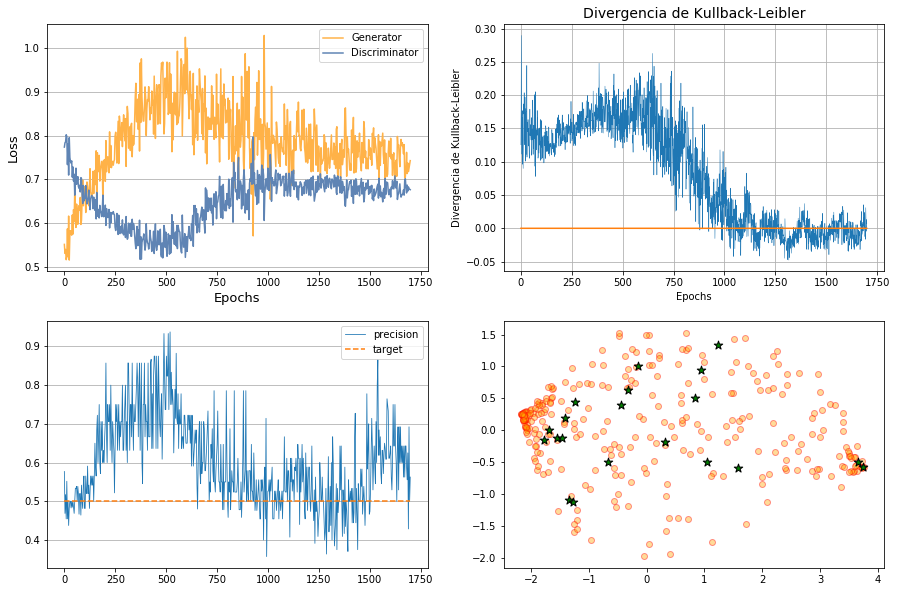

In [17]:
p = utils.plot_results(syn_size=300)

In [18]:
def boxtplot_values(v):
    """
    parameters: 
        v: array with the values to make a boxplot
    return the values to plot a boxplot in the bokeh library
    return: [lower, quantile25, quantile50, quantile75, upper] and outliers
    """
    q25 = np.quantile(v, q=.25, interpolation="midpoint")
    q50 = np.quantile(v, q=.5, interpolation="midpoint")
    q75 = np.quantile(v, q=.75, interpolation="midpoint")
    lower = q25 - 1.5*(q75-q25)
    upper = q75 + 1.5*(q75-q25)
    #outliers
    outliers = v[(v<lower)|(v>upper)]

    return [lower, q25, q50, q75, upper], outliers

In [19]:
p_d, kld, l_g, l_d = utils.get_metrics(num_iter=300)

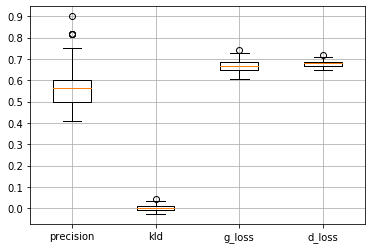

In [20]:
plt.boxplot([p_d, kld, l_g, l_d]);
#plt.yscale("logit")
plt.grid(axis="both");
plt.xticks(ticks=[1,2,3,4], labels=["precision", "kld", "g_loss", "d_loss"]);
plt.yticks(ticks=np.arange(0,1,.1), labels=np.round(np.arange(0,1.1,.1), 2));

#### Boxplot with Bokeh library
- I'm using the bokeh library to make a better plot.

In [21]:
from bokeh.plotting import output_notebook, figure, show, output_file
from bokeh.layouts import gridplot
from bokeh.palettes import OrRd, Greens, Set3, RdYlBu, YlGnBu
output_notebook()

[pl, pq1, pq2, pq3, pu], pouts = boxtplot_values(np.array(p_d))
[kldl, kldq1, kldq2, kldq3, kldu], kldouts = boxtplot_values(np.array(kld))
[lgl, lgq1, lgq2, lgq3, lgu], lgouts = boxtplot_values(np.array(l_g))
[ldl, ldq1, ldq2, ldq3, ldu], ldouts = boxtplot_values(np.array(l_d))

Loading BokehJS ...

In [22]:
#precision of the discriminator network
cats = ["Discriminador"]
p = figure(tools="", background_fill_color="#ffffff", x_range=cats, toolbar_location=None,
          plot_height=250, plot_width=220, )
p.segment(cats, [pl], cats, [pq1], line_color="black")
p.segment(cats, [pq3], cats, [pu], line_color="black")
p.vbar(cats, 0.2, [pq1], [pq2], fill_color="#E08E79", line_color="black")
p.vbar(cats, 0.2, [pq2], [pq3], fill_color="#3B8686", line_color="black")
p.rect(cats, [pl], 0.2, 0.0001, line_color="black")
p.rect(cats, [pu], 0.2, 0.0001, line_color="black")
p.circle([cats[0] for i in range(len(np.unique(pouts)))], np.unique(pouts),
         size=6, color="#F38630", fill_alpha=0.6, legend="outliers")
p.legend.background_fill_alpha = 0.0
p.yaxis.axis_label = "Precisão"
#p.legend.location = (80, 100)

#Kullback-Leibler divergence
p1 = figure(tools="", background_fill_color="#ffffff", x_range=cats, toolbar_location=None,
          plot_height=250, plot_width=220, )
p1.segment(cats, [kldl], cats, [kldq1], line_color="black")
p1.segment(cats, [kldq3], cats, [kldu], line_color="black")
p1.vbar(cats, 0.23, [kldq1], [kldq2], fill_color=Set3[3][0], line_color="black")
p1.vbar(cats, 0.23, [kldq2], [kldq3], fill_color=Set3[3][2], line_color="black")
p1.rect(cats, [kldl], 0.2, 0.0001, line_color="black")
p1.rect(cats, [kldu], 0.2, 0.0001, line_color="black")
p1.circle([cats[0] for i in range(len(np.unique(kldouts)))], np.unique(kldouts),
         size=6, color="#F38630", fill_alpha=0.6, legend="outliers")
p1.legend.background_fill_alpha = 0.0
p1.yaxis.axis_label = "Divergência de Kullback-Leibler"

#cost function of the generator network
cats_g = ["Generador"]
p2 = figure(tools="", background_fill_color="#ffffff", x_range=cats_g, toolbar_location=None,
          plot_height=250, plot_width=220, )
p2.segment(cats_g, [lgl], cats_g, [lgq1], line_color="black")
p2.segment(cats_g, [lgq3], cats_g, [lgu], line_color="black")
p2.vbar(cats_g, 0.23, [lgq1], [lgq2], fill_color=RdYlBu[3][0], line_color="black")
p2.vbar(cats_g, 0.23, [lgq2], [lgq3], fill_color=RdYlBu[3][1], line_color="black")
p2.rect(cats_g, [lgl], 0.2, 0.0001, line_color="black")
p2.rect(cats_g, [lgu], 0.2, 0.0001, line_color="black")
p2.circle([cats_g[0] for i in range(len(np.unique(lgouts)))], np.unique(lgouts),
         size=6, color="#F38630", fill_alpha=0.6, legend="outliers")
p2.legend.background_fill_alpha = 0.0
p2.yaxis.axis_label = "Função de custo"

#cost function of the discriminator network
p3 = figure(tools="", background_fill_color="#ffffff", x_range=cats, toolbar_location=None,
          plot_height=250, plot_width=220, )
p3.segment(cats, [ldl], cats, [ldq1], line_color="black")
p3.segment(cats, [ldq3], cats, [ldu], line_color="black")
p3.vbar(cats, 0.23, [ldq1], [ldq2], fill_color=YlGnBu[3][0], line_color="black")
p3.vbar(cats, 0.23, [ldq2], [ldq3], fill_color=YlGnBu[3][1], line_color="black")
p3.rect(cats, [ldl], 0.2, 0.0001, line_color="black")
p3.rect(cats, [ldu], 0.2, 0.0001, line_color="black")
p3.circle([cats[0] for i in range(len(np.unique(ldouts)))], np.unique(ldouts),
         size=6, color="#F38630", fill_alpha=0.6, legend="outliers")
p3.legend.background_fill_alpha = 0.0
p3.yaxis.axis_label = "Função de custo"


show(gridplot([[p, p1],[p2, p3]], plot_width=280))

#### Gaussian noise generator

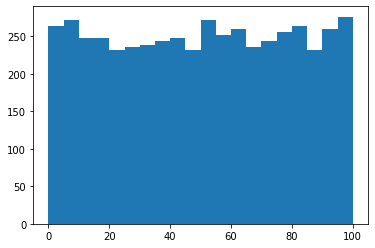

In [22]:
a = np.random.randint(0,101, size=5000)
plt.hist(a, bins=20);

In [44]:
class gaussian_noise_samples:
    """
    Gaussian noise samples allows generate synthetic samples based in a real samples.
    This method adds Gaussian noise to a real example.
    parameters:
        - mu: mean of the gaussian distribution
        - sigma: standard desviation of the gaussian distribution
    Methods:
        - get_syn_samples
    """
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def get_syn_samples(self, x, n):
        """
        Inputs:
            T: 2D-data array to be increase
            N: Percentage of synthetic samples N%.
        """
        if n < 100:
            idxs = np.random.choice(range(len(x)), size=int(len(x)*(n/100)), replace=False)
            x = x[idxs, :]
            n = 100
        
        n = int(n/100)*len(x)
        synthetic_samples = np.ones((n, x.shape[1]))
        #generating synthetic samples
        for i in range(n):
            #getting a random real sample
            idx = np.random.randint(0, x.shape[1]+1)
            synthetic_samples[i] = x[idx] + np.random.normal(self.mu, self.sigma, size=(x.shape[1]))
    
        return synthetic_samples

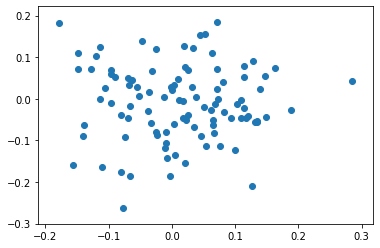

In [45]:
x = np.ones((100,2))*np.random.normal(0, .1, size=(100,2))
plt.scatter(x[:,0], x[:,1]);

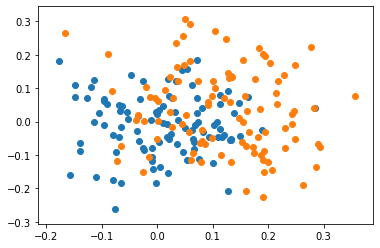

In [62]:
obj = gaussian_noise_samples(0,.1)
x_sin = obj.get_syn_samples(x, 150)
plt.scatter(x[:,0], x[:,1]);
plt.scatter(x_sin[:,0], x_sin[:,1]);